In [3]:
# Get access to data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Import required libraries
!pip install segyio
!pip install "dask[complete]"
import segyio
import numpy as np
import pandas as pd
import dask.array as da
import dask.dataframe as ddf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
print ("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
seismic_data_path = '/content/drive/My Drive/Colab Notebooks/F3_Seismic_C.sgy'  # Store the file path
seismic_data = segyio.tools.cube(seismic_data_path)  # Load data using the path

In [3]:
# Inspect Seismic Data
with segyio.open(seismic_data_path, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 80601, N Samples: 151, Sample rate: 4.0ms, Trace length: 1100.0'

In [4]:
f = segyio.open(seismic_data_path, xline=segyio.tracefield.TraceField.CDP)
il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape
itmin,itmax = int(t[0]), int(t[-1])

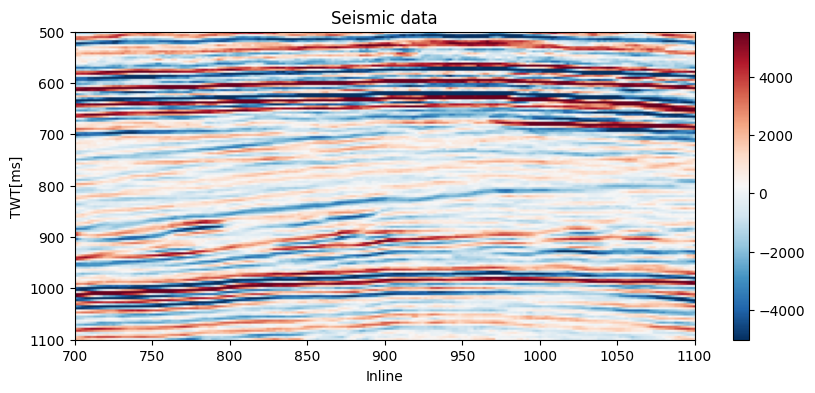

In [6]:
# Plot seismic section
plt.figure(figsize=(10, 4))
plt.imshow(d[:,50,:].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], t[-1], t[0]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT[ms]')
plt.show()

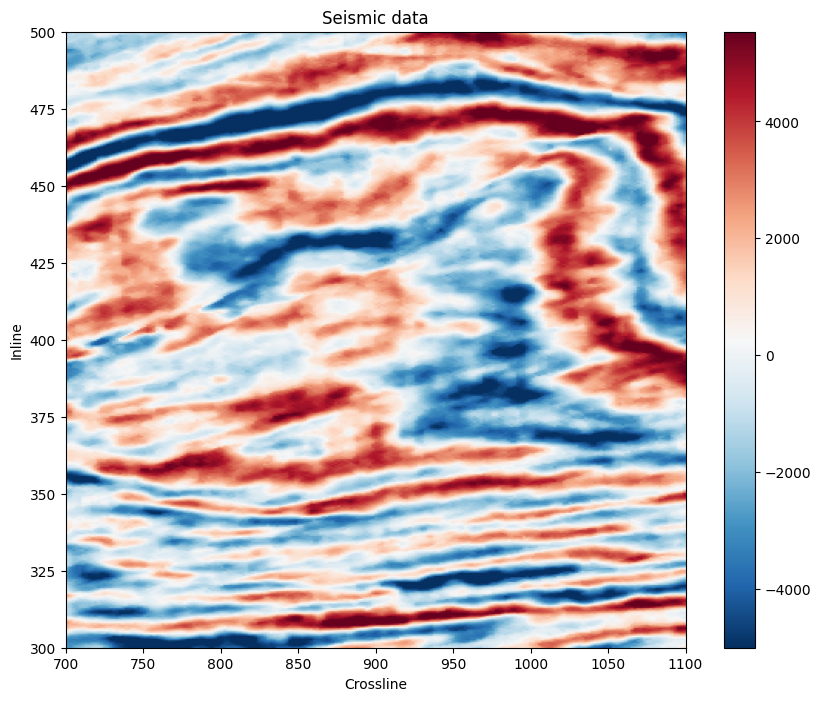

In [7]:
# Plot time slice
plt.figure(figsize=(10, 8))
plt.imshow(d[:,:,120].T, cmap='RdBu_r',
           extent=(xl[0], xl[-1], il[0], il[-1]),
           vmin=np.percentile(d, 2),
           vmax=np.percentile(d, 98))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Crossline')
plt.ylabel('Inline')
plt.show()

In [8]:
# Load seismic attributes
# Velocity
seismic_velocity_path = '/content/drive/My Drive/F3_Velocity_C.sgy'  # Store the file path
F3_Velocity_Data = segyio.tools.cube(seismic_velocity_path)  # Load data using the path
# freq_absorb
freq_absorb_path = '/content/drive/My Drive/Colab Notebooks/freq_absorb.sgy'  # Store the file path
freq_absorb = segyio.tools.cube(freq_absorb_path)  # Load data using the path
# insta_amp
insta_amp_path = '/content/drive/My Drive/Colab Notebooks/insta_amp.sgy'  # Store the file path
insta_amp = segyio.tools.cube(insta_amp_path)  # Load data using the path
# insta_hilbert
insta_hilbert_path = '/content/drive/My Drive/Colab Notebooks/insta_hilbert.sgy'  # Store the file path
insta_hilbert = segyio.tools.cube(insta_hilbert_path)  # Load data using the path
# pseudo_relief
pseudo_relief_path = '/content/drive/My Drive/Colab Notebooks/pseudo_relief.sgy'  # Store the file path
pseudo_relief = segyio.tools.cube(pseudo_relief_path)  # Load data using the path
# spectral_decomp
spectral_decomp_path = '/content/drive/My Drive/Colab Notebooks/spectral_decomp.sgy'  # Store the file path
spectral_decomp = segyio.tools.cube(spectral_decomp_path)  # Load data using the path
print ("Data loaded successfully!")


Data loaded successfully!


In [9]:
# Flatten the seismic attributes 3D cubes
Velocity_Data_f= F3_Velocity_Data.flatten()
freq_absorb_f= freq_absorb.flatten()
insta_amp_f= insta_amp.flatten()
insta_hilbert_f= insta_hilbert.flatten()
pseudo_relief_f= pseudo_relief.flatten()
spectral_decomp_f= spectral_decomp.flatten()

# Create list to make a dataframe of the Seismic 3D cubes
names = ['F3_Velocity_Data', 'freq_absorb', 'insta_amp', 'insta_hilbert', 'pseudo_relief', 'spectral_decomp']
seismic_df = [Velocity_Data_f, freq_absorb_f, insta_amp_f, insta_hilbert_f, pseudo_relief_f, spectral_decomp_f ]


# Create daskdataframe of the Seismic 3D cubes
seismic_df = da.stack(seismic_df, axis=1)
seismic_df = ddf.from_dask_array(seismic_df, columns=names).compute()

# check results
seismic_df

,F3_Velocity_Data,freq_absorb,insta_amp,insta_hilbert,pseudo_relief,spectral_decomp
0,1934.559570,1.138966e+11,-1819.0,-1077.727295,-4.458501e+06,5765.488281
1,1937.196045,9.146453e+10,-711.0,-2274.618164,6.163898e+05,6237.683594
2,1939.779541,8.487875e+10,1475.0,-2290.942383,2.954568e+06,6186.242188
3,1942.311035,8.118331e+10,3070.0,-27.140488,9.566294e+05,5510.765625
4,1944.791992,5.898487e+10,1334.0,2656.842285,-6.434117e+06,4721.160156
...,...,...,...,...,...,...
12170746,2067.752686,7.786712e+10,2141.0,707.257812,-1.602355e+06,8754.828125
12170747,2067.870361,6.817440e+10,786.0,2166.420410,-7.634472e+05,8719.605469
12170748,2067.976074,5.580732e+10,-851.0,2161.849121,1.516097e+06,8365.808594
12170749,2068.069824,6.166768e+10,-1965.0,993.804932,3.302810e+06,8615.675781


In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the data and transform it
seismic_df_sc = scaler.fit_transform(seismic_df)

# Convert the result back to a DataFrame
seismic_df_std = pd.DataFrame(seismic_df_sc, columns=seismic_df.columns)

# check results
seismic_df_std

,F3_Velocity_Data,freq_absorb,insta_amp,insta_hilbert,pseudo_relief,spectral_decomp
0,-2.446964,-0.277784,-0.767618,-0.450685,-0.436305,-0.257094
1,-2.367978,-0.429995,-0.302776,-0.952545,0.082088,-0.136449
2,-2.290579,-0.474683,0.614322,-0.959389,0.320930,-0.149592
3,-2.214738,-0.499758,1.283477,-0.010171,0.116843,-0.322175
4,-2.140411,-0.650385,0.555168,1.115231,-0.638112,-0.523917
...,...,...,...,...,...,...
12170746,1.543362,-0.522260,0.893731,0.297765,-0.144554,0.506675
12170747,1.546888,-0.588030,0.325264,0.909596,-0.058860,0.497675
12170748,1.550055,-0.671946,-0.361511,0.907679,0.173992,0.407281
12170749,1.552863,-0.632181,-0.828870,0.417915,0.356503,0.471122


In [11]:
# load the Models
import joblib
LR = joblib.load('/content/drive/MyDrive/Colab Notebooks/random_forest_model.pkl')
RFR = joblib.load('/content/drive/MyDrive/Colab Notebooks/linear_regression_model.pkl')
NN = joblib.load('/content/drive/MyDrive/Colab Notebooks/neural_network_model.pkl')
print("Models loaded successfully!")

Models loaded successfully!


In [12]:
# Get the feature names used during training
training_features = LR.feature_names_in_

# Reorder the columns of seismic_df_std to match the training data
seismic_df_std = seismic_df_std[training_features]

# Now you can predict using the reordered dataframe
Predicted_VSh_LR = LR.predict(seismic_df_std)
print("LR Model applied successfully!")

LR Model applied successfully!


In [13]:
# apply the model to the seismic data
# 2. Random Forest Model
%time
Predicted_VSh_RFR = RFR.predict(seismic_df_std)
print("RFR Model applied successfully!")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs
RFR Model applied successfully!


In [14]:
# apply the model to the seismic data
# 3. Neural Network Model
%time
Predicted_VSh_NN = NN.predict(seismic_df_std)
print("MLP Model applied successfully!")

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.4 µs
MLP Model applied successfully!


In [15]:
# Reshape resultant volumes
VSh_LR = Predicted_VSh_LR.reshape(seismic_data.shape)
VSh_RFR = Predicted_VSh_RFR.reshape(seismic_data.shape)
VSh_NN = Predicted_VSh_NN.reshape(seismic_data.shape)
print("Reshaped successfully!")

Reshaped successfully!


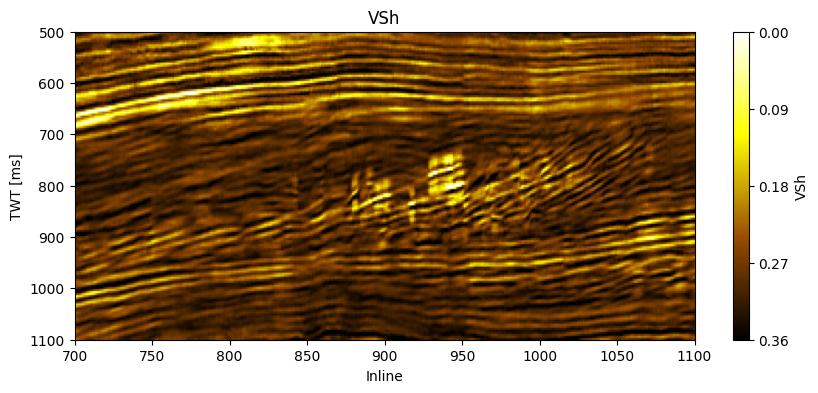

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define a custom colormap with gradients
colors = [(1, 1, 1),  # White for values less than 0.25
          (1, 1, 0),  # Yellow at 0.25
          (0.6, 0.3, 0),  # Brown at 0.31
          (0, 0, 0)]  # Black at 0.36

# Normalize values to be between 0 and 1
values = [0, 0.25, 0.31, 0.36]
normalized_values = np.linspace(0, 1, len(values))

cmap = mcolors.LinearSegmentedColormap.from_list("VSh", list(zip(normalized_values, colors)))

# Plotting VSh Section
plt.figure(figsize=(10, 4))
im = plt.imshow(VSh_RFR[100, :, :].T, cmap=cmap,
                extent=(xl[0], xl[-1], t[-1], t[0]),
                vmin=0, vmax=0.36)
plt.title('VSh')

# Add colorbar with values and title
cbar = plt.colorbar(im)
cbar.ax.invert_yaxis()
cbar.set_label("VSh")

# Set evenly spaced ticks
num_ticks = 5
cbar.set_ticks(np.linspace(0, 0.36, num_ticks))
cbar.set_ticklabels([f'{v:.2f}' for v in np.linspace(0, 0.36, num_ticks)])

plt.axis('tight')
plt.xlabel('Inline')
plt.ylabel('TWT [ms]')

plt.savefig("VSh_output.png", dpi=1200, bbox_inches='tight')
plt.show()




In [ ]:
#@title Export the Porosity
!git clone https://github.com/otavioon/d2geo.git
import h5py
from d2geo.attributes.io import segy_read, segy_write
from shutil import copyfile as cf
output = segy_write(VSh_RFR, seismic_data_path, '/content/drive/MyDrive/Colab Notebooks/VSh_RFR.segy')
print('Done Exporting')

Cloning into 'd2geo'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 68 (delta 28), reused 28 (delta 28), pack-reused 36 (from 1)
Receiving objects: 100% (68/68), 50.64 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (37/37), done.


/usr/local/lib/python3.11/dist-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


Done Exporting
